In [ ]:
% pip install tensorflow

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
from tensorflow.keras.datasets import mnist
import numpy as np
import cv2
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
def load_mnist_dataset():

  # load data from tensorflow framework
  ((trainData, trainLabels), (testData, testLabels)) = mnist.load_data() 

  # Stacking train data and test data to form single array named data
  data = np.vstack([trainData, testData]) 

  # Vertical stacking labels of train and test set
  labels = np.hstack([trainLabels, testLabels]) 

  # return a 2-tuple of the MNIST data and labels
  return (data, labels)

def load_az_dataset(datasetPath):

  # List for storing data
  data = []
  
  # List for storing labels
  labels = []
  
  for row in open(datasetPath): #Openfile and start reading each row
    #Split the row at every comma
    row = row.split(",")
    
    #row[0] contains label
    label = int(row[0])
    
    #Other all collumns contains pixel values make a saperate array for that
    image = np.array([int(x) for x in row[1:]], dtype="uint8")
    
    #Reshaping image to 28 x 28 pixels
    image = image.reshape((28, 28))
    
    #append image to data
    data.append(image)
    
    #append label to labels
    labels.append(label)
    
  #Converting data to numpy array of type float32
  data = np.array(data, dtype='float32')
  
  #Converting labels to type int
  labels = np.array(labels, dtype="int")
  
  return (data, labels)

def load_74k_dataset(dataset_path):
  pass

In [4]:
(digitsData, digitsLabels) = load_mnist_dataset()

# (azData, azLabels) = load_az_dataset('drive/MyDrive/Dataset/Kaggel AZ/Data/A_Z Handwritten Data.csv')
(azData, azLabels) = load_az_dataset('Datasets/A_Z Handwritten Data.csv')

In [9]:
# the MNIST dataset occupies the labels 0-9, so let's add 10 to every A-Z label to ensure the A-Z characters are not incorrectly labeled 

azLabels += 10

# stack the A-Z data and labels with the MNIST digits data and labels

data = np.vstack([azData, digitsData])
labels = np.hstack([azLabels, digitsLabels])

# Each image in the A-Z and MNIST digts datasets are 28x28 pixels;
# However, the architecture we're using is designed for 32x32 images,
# So we need to resize them to 32x32

data = [cv2.resize(image, (32, 32)) for image in data]
data = np.array(data, dtype="float32")

# add a channel dimension to every image in the dataset and scale the
# pixel intensities of the images from [0, 255] down to [0, 1]

data = np.expand_dims(data, axis=-1)
data /= 255.0

In [10]:
le = LabelBinarizer()
labels = le.fit_transform(labels)
counts = labels.sum(axis=0)

# account for skew in the labeled data
classTotals = labels.sum(axis=0)
classWeight = {}

# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
  classWeight[i] = classTotals.max() / classTotals[i]


In [11]:
# construct the image generator for data augmentation

aug = ImageDataGenerator(
rotation_range=10,
zoom_range=0.05,
width_shift_range=0.1,
height_shift_range=0.1,
shear_range=0.15,
horizontal_flip=False,
fill_mode="nearest")

In [12]:
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import AveragePooling2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D
from keras.layers.core import Activation
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.layers import add
from keras.regularizers import l2
from keras import backend as K

class ResNet:
	@staticmethod
	def residual_module(data, K, stride, chanDim, red=False,
		reg=0.0001, bnEps=2e-5, bnMom=0.9):
		# the shortcut branch of the ResNet module should be
		# initialize as the input (identity) data
		shortcut = data

		# the first block of the ResNet module are the 1x1 CONVs
		bn1 = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(data)
		act1 = Activation("relu")(bn1)
		conv1 = Conv2D(int(K * 0.25), (1, 1), use_bias=False,
			kernel_regularizer=l2(reg))(act1)

		# the second block of the ResNet module are the 3x3 CONVs
		bn2 = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(conv1)
		act2 = Activation("relu")(bn2)
		conv2 = Conv2D(int(K * 0.25), (3, 3), strides=stride,
			padding="same", use_bias=False,
			kernel_regularizer=l2(reg))(act2)

		# the third block of the ResNet module is another set of 1x1
		# CONVs
		bn3 = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(conv2)
		act3 = Activation("relu")(bn3)
		conv3 = Conv2D(K, (1, 1), use_bias=False,
			kernel_regularizer=l2(reg))(act3)

		# if we are to reduce the spatial size, apply a CONV layer to
		# the shortcut
		if red:
			shortcut = Conv2D(K, (1, 1), strides=stride,
				use_bias=False, kernel_regularizer=l2(reg))(act1)

		# add together the shortcut and the final CONV
		x = add([conv3, shortcut])

		# return the addition as the output of the ResNet module
		return x

	@staticmethod
	def build(width, height, depth, classes, stages, filters,
		reg=0.0001, bnEps=2e-5, bnMom=0.9, dataset="cifar"):
		# initialize the input shape to be "channels last" and the
		# channels dimension itself
		inputShape = (height, width, depth)
		chanDim = -1

		# if we are using "channels first", update the input shape
		# and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1

		# set the input and apply BN
		inputs = Input(shape=inputShape)
		x = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(inputs)

		# check if we are utilizing the CIFAR dataset
		if dataset == "cifar":
			# apply a single CONV layer
			x = Conv2D(filters[0], (3, 3), use_bias=False,
				padding="same", kernel_regularizer=l2(reg))(x)

		# check to see if we are using the Tiny ImageNet dataset
		elif dataset == "tiny_imagenet":
			# apply CONV => BN => ACT => POOL to reduce spatial size
			x = Conv2D(filters[0], (5, 5), use_bias=False,
				padding="same", kernel_regularizer=l2(reg))(x)
			x = BatchNormalization(axis=chanDim, epsilon=bnEps,
				momentum=bnMom)(x)
			x = Activation("relu")(x)
			x = ZeroPadding2D((1, 1))(x)
			x = MaxPooling2D((3, 3), strides=(2, 2))(x)

		# loop over the number of stages
		for i in range(0, len(stages)):
			# initialize the stride, then apply a residual module
			# used to reduce the spatial size of the input volume
			stride = (1, 1) if i == 0 else (2, 2)
			x = ResNet.residual_module(x, filters[i + 1], stride,
				chanDim, red=True, bnEps=bnEps, bnMom=bnMom)

			# loop over the number of layers in the stage
			for j in range(0, stages[i] - 1):
				# apply a ResNet module
				x = ResNet.residual_module(x, filters[i + 1],
					(1, 1), chanDim, bnEps=bnEps, bnMom=bnMom)

		# apply BN => ACT => POOL
		x = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(x)
		x = Activation("relu")(x)
		x = AveragePooling2D((8, 8))(x)

		# softmax classifier
		x = Flatten()(x)
		x = Dense(classes, kernel_regularizer=l2(reg))(x)
		x = Activation("softmax")(x)

		# create the model
		model = Model(inputs, x, name="resnet")

		# return the constructed network architecture
		return model

In [15]:
# trainX = data[:int(0.9*len(data))]
# trainY = labels[:int(0.9*len(data))]
# testX = data[int(0.9*len(data)):]
# testY = labels[int(0.9*len(data)):]
from sklearn.model_selection import train_test_split

trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.2, random_state=42)
print(testX.shape)
print(testY.shape)

(88491, 32, 32, 1)
(88491, 36)


In [29]:
from tensorflow.keras.optimizers import SGD
EPOCHS = 2
INIT_LR = 1e-1
BS = 128

opt = SGD(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)

model = ResNet.build(32, 32, 1, len(le.classes_), (3, 3, 3),
(64, 64, 128, 256), reg=0.0005)

model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

H = model.fit(
aug.flow(trainX, trainY, batch_size=BS),
validation_data=(testX, testY),
steps_per_epoch=len(trainX) // BS,epochs=EPOCHS,
class_weight=classWeight,
verbose=1)

Epoch 1/2
2765/2765 [==============================] - 438s 157ms/step - loss: 5.1537 - accuracy: 0.7456 - val_loss: 0.8365 - val_accuracy: 0.8634
Epoch 2/2
2765/2765 [==============================] - 419s 152ms/step - loss: 2.7355 - accuracy: 0.8485 - val_loss: 0.7335 - val_accuracy: 0.8728


In [30]:
from sklearn.metrics import classification_report
labelNames = "0123456789"

labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

labelNames = [l for l in labelNames]

predictions = model.predict(testX, batch_size=BS)

print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))

              precision    recall  f1-score   support

           0       0.20      0.68      0.30      1395
           1       0.96      0.96      0.96      1590
           2       0.81      0.74      0.77      1395
           3       0.86      0.96      0.91      1441
           4       0.81      0.85      0.83      1384
           5       0.45      0.75      0.56      1265
           6       0.87      0.91      0.89      1341
           7       0.90      0.95      0.92      1519
           8       0.77      0.94      0.84      1368
           9       0.88      0.96      0.91      1383
           A       0.94      0.97      0.95      2721
           B       0.94      0.90      0.92      1733
           C       0.96      0.95      0.96      4637
           D       0.88      0.83      0.85      2067
           E       0.99      0.93      0.96      2297
           F       0.94      0.98      0.96       215
           G       0.89      0.88      0.89      1185
           H       0.92    

In [ ]:
model.save('OCR_Resnet.h5',save_format=".h5")

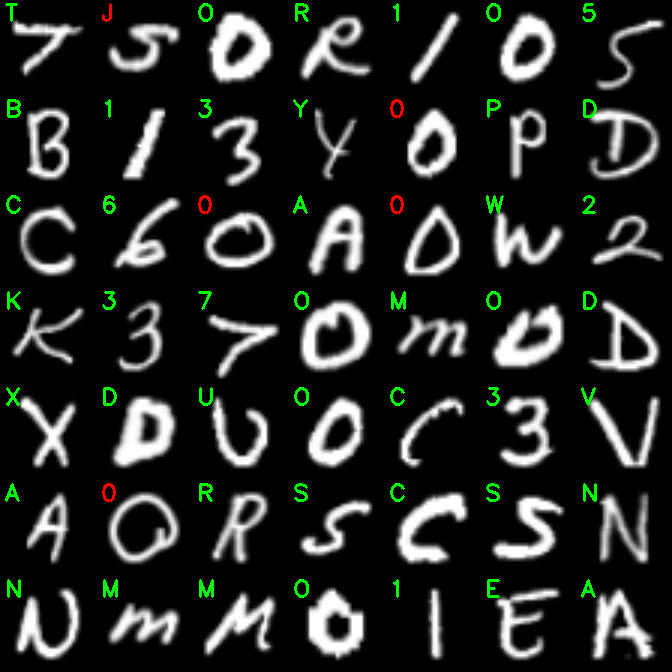

-1

In [63]:
images = []
from imutils import build_montages
from google.colab.patches import cv2_imshow
# randomly select a few testing characters
output = []
for i in np.random.choice(np.arange(0, len(testY)), size=(49,)):
  probs = model.predict(testX[np.newaxis, i])
  prediction = probs.argmax(axis=1)
  label = labelNames[prediction[0]]
  output+=label
  image = (testX[i] * 255).astype("uint8")
  color = (0, 255, 0)
  if prediction[0] != np.argmax(testY[i]):
    color = (0, 0, 255)
  image = cv2.merge([image] * 3)
  image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
  cv2.putText(image, label, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
  color, 2)
  images.append(image)
  
montage = build_montages(images, (96, 96), (7, 7))[0]
cv2_imshow(montage)
cv2.waitKey(0)

In [246]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import imutils
from imutils.contours import sort_contours
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def predict(file_path):
  test_image = tf.keras.preprocessing.image.load_img(file_path)
  src = cv2.imread(file_path)
  gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray, (5, 5), 0)
  # edged = cv2.Canny(blurred, 30, 150)
  edged = cv2.Canny(blurred, 30, 150)
  plt.imshow(edged)
  cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  cnts = sort_contours(cnts, method="left-to-right")[0]
  chars = []
  for c in cnts:
      # compute the bounding box of the contour
      (x, y, w, h) = cv2.boundingRect(c)
      # filter out bounding boxes, ensuring they are neither too small
      # nor too large
      if (w >= 5 and w <= 150) and (h >= 15 and h <= 120):
          # extract the character and threshold it to make the character
          # appear as *white* (foreground) on a *black* background, then
          # grab the width and height of the thresholded image
          roi = gray[y:y + h, x:x + w]
          thresh = cv2.threshold(roi, 0, 255,
                                  cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
          (tH, tW) = thresh.shape
          # if the width is greater than the height, resize along the
          # width dimension
          if tW > tH:
              thresh = imutils.resize(thresh, width=32)
          # otherwise, resize along the height
          else:
              thresh = imutils.resize(thresh, height=32)
          # re-grab the image dimensions (now that its been resized)
          # and then determine how much we need to pad the width and
          # height such that our image will be 32x32
          (tH, tW) = thresh.shape
          dX = int(max(0, 32 - tW) / 2.0)
          dY = int(max(0, 32 - tH) / 2.0)
          # pad the image and force 32x32 dimensions
          padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
                                      left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
                                      value=0)
          padded = cv2.resize(padded, (32, 32))
          # prepare the padded image for classification via our
          # handwriting OCR model
          padded = padded.astype("float32") / 255.0
          padded = np.expand_dims(padded, axis=-1)
          # update our list of characters that will be OCR'd
          chars.append((padded, (x, y, w, h)))
  boxes = [b[1] for b in chars]
  chars = np.array([c[0] for c in chars], dtype="float32")
  new=np.squeeze(chars[2], axis=2)
  # OCR the characters using our handwriting recognition model
  preds = model.predict(chars)
  # define the list of label names
  labelNames = "0123456789"
  labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
  labelNames = [l for l in labelNames]
  output = ""
  for (pred, (x, y, w, h)) in zip(preds, boxes):
      i = np.argmax(pred)
      prob = pred[i]
      label = labelNames[i]
      output += label
  print("prediction:",output)

  im = Image.open(file_path)
  
  # Create figure and axes
  fig, ax = plt.subplots()

  # Display the image
  ax.imshow(im)

  # Create a Rectangle patch
  # Add the patch to the Axes
  for box in boxes:
    rect = patches.Rectangle((box[0],box[1]),box[2],box[3], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
  # img = mpimg.imread(file_path)
  # plt.imshow()

prediction: BHQBDOA


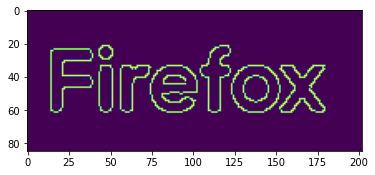

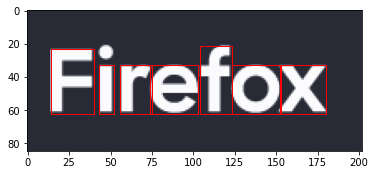

In [247]:
predict('firefox.png')